In [1]:
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.4 MB/s 
     |████████████████████████████████| 120 kB 54.7 MB/s 


In [2]:
#!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.7 MB/s 


In [3]:
#!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 6.8 MB/s 
     |████████████████████████████████| 115 kB 68.8 MB/s 
     |████████████████████████████████| 212 kB 65.8 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import datasets

In [5]:
from datasets import list_datasets
from datasets import load_dataset

In [6]:
import numpy as np
import torch
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [7]:
from google.colab import output
output.enable_custom_widget_manager()

In [8]:
from datasets import Features, ClassLabel, Value
class_names = ["Hope_speech", "Non_hope_speech", "not-Malayalam"]
hope_edi_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})
hope_edi = load_dataset('csv', data_files={'train':'/content/preprocessed_hope_edi_mal_train.csv', 'validation':'/content/preprocessed_hope_edi_mal_valid.csv'}, features=hope_edi_features)

Generating train split:   0%|          | 0/8564 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1070 [00:00<?, ? examples/s]

Dataset hope_edi downloaded and prepared to /root/.cache/huggingface/datasets/hope_edi/malayalam/1.0.0/fff5cf6e767fe3d1de7c5df863565bdce10bfe79dfb0b2ce42d320c3864497e3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
hope_edi

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8564
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1070
    })
})

In [10]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [11]:
train_ds = hope_edi["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 8564
})

In [12]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['Hope_speech', 'Non_hope_speech', 'not-malayalam'], id=None)}


In [13]:
import pandas as pd

hope_edi.set_format(type="pandas")
df = hope_edi["train"][:]
train_labels = df['label'].values
df.head()

,text,label
0,@arya s nair may be athile karthikayude charct...,1
1,വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...,1
2,മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...,0
3,ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...,1
4,ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...,0


In [14]:
def label_int2str(row):
    return hope_edi["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,@arya s nair may be athile karthikayude charct...,1,Non_hope_speech
1,വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...,1,Non_hope_speech
2,മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...,0,Hope_speech
3,ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...,1,Non_hope_speech
4,ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...,0,Hope_speech


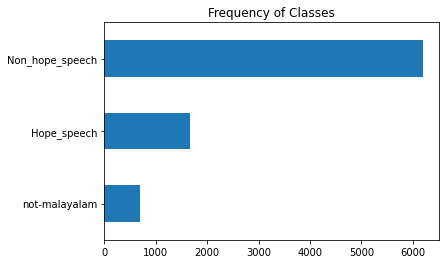

In [15]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [17]:
hope_edi.reset_format()

In [18]:
batch_size = 16
learning_rate = 5e-5
epochs = 6
weight_decay = 0.01
max_len = 256

In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    p = precision_score(labels, preds, average="weighted")
    r = recall_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, 'precision': p, 'recall': r}

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    cm1 = confusion_matrix(y_true, y_preds)
    fig = plt.figure(figsize=(20,10))
    fig.subplots(2, 1, squeeze=False)
    ax1 = plt.subplot(2,1,1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax1, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax2 = plt.subplot(2,1,2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
    disp.plot(cmap="Greens", ax=ax2, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

In [22]:
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers import Trainer

class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [42]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
tokenizer.model_max_length=max_len

In [25]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [26]:
tokenizer.vocab_size

119547

In [27]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [28]:
print(tokenize(hope_edi["train"][:2]))

{'input_ids': [[101, 137, 13226, 10113, 187, 76206, 10129, 11387, 10347, 10160, 53543, 10112, 82612, 87600, 13998, 17756, 101328, 14526, 10129, 10467, 28580, 17907, 11538, 19334, 70691, 10147, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1364, 24458, 105779, 17676, 1328, 43877, 17676, 1334, 18384, 43877, 36655, 1322, 18395, 79591, 26256, 1334, 71430, 18395, 20525, 1353, 58369, 37591, 37591, 27921, 1323, 66568, 1364, 24458, 69718, 111385, 24458, 22945, 39508, 57764, 1365, 24164, 23290, 101483, 52388, 24164, 17896, 107033, 28248, 10116, 11098, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
#hide_input
import pandas as pd
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [30]:
hope_edi_encoded = hope_edi.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
print(hope_edi_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [23]:
from datasets import Features, ClassLabel, Value
class_names = ["Hope_speech", "Non_hope_speech", "not-Malayalam"]
hope_edi_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})
hope_edi_test = load_dataset('csv', data_files={'test':'/content/preprocessed_hope_edi_mal_test.csv'}, features=hope_edi_features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8a8bd7acc7a6c432/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
hope_edi_test

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1071
    })
})

In [34]:
hope_edi_test_encoded = hope_edi_test.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [37]:
from transformers import Trainer, TrainingArguments

epochs = 3
logging_steps = len(hope_edi_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
model_name = f"{model_ckpt}-finetuned-hope"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [38]:
trainer = CustomTrainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_encoded["train"],
                  eval_dataset=hope_edi_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479100,0.482381,0.784112,0.791950,0.805885,0.784112
2,0.304000,0.446499,0.826168,0.817404,0.816701,0.826168
3,0.193400,0.552955,0.836449,0.834664,0.833328,0.836449


In [39]:
preds_output = trainer.predict(hope_edi_encoded["validation"])
preds_output.metrics

{'test_loss': 0.5529554486274719,
 'test_accuracy': 0.8364485981308412,
 'test_f1': 0.8346643789715932,
 'test_precision': 0.8333281928909283,
 'test_recall': 0.8364485981308412,
 'test_runtime': 4.6434,
 'test_samples_per_second': 230.433,
 'test_steps_per_second': 14.429}

In [40]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(hope_edi_encoded["validation"]["label"])
labels = hope_edi_encoded["train"].features["label"].names

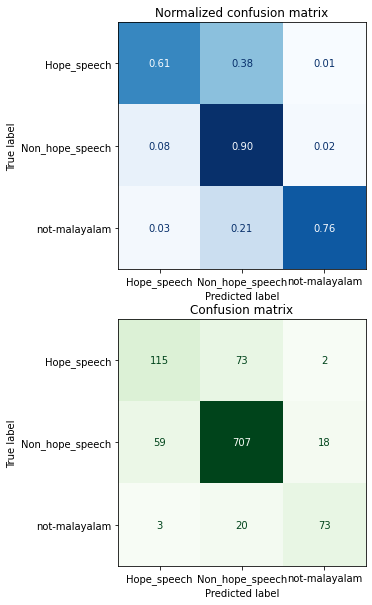

In [41]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_preds))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       190
           1       0.88      0.90      0.89       784
           2       0.78      0.76      0.77        96

    accuracy                           0.84      1070
   macro avg       0.77      0.76      0.76      1070
weighted avg       0.83      0.84      0.83      1070



In [43]:
preds_train = trainer.predict(hope_edi_encoded["train"])
y_pred_train = np.argmax(preds_train.predictions, axis=1)
y_train = np.array(hope_edi_encoded["train"]["label"])
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1668
           1       0.97      0.98      0.97      6205
           2       0.98      0.99      0.98       691

    accuracy                           0.96      8564
   macro avg       0.95      0.95      0.95      8564
weighted avg       0.96      0.96      0.96      8564



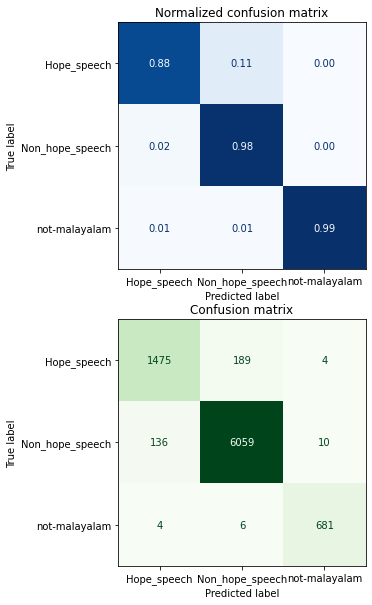

In [44]:
plot_confusion_matrix(y_pred_train, y_train, labels)

In [45]:
preds_test = trainer.predict(hope_edi_test_encoded["test"])
y_pred_test = np.argmax(preds_test.predictions, axis=1)
y_test = np.array(hope_edi_test_encoded["test"]["label"])
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       194
           1       0.89      0.92      0.91       776
           2       0.91      0.77      0.83       101

    accuracy                           0.86      1071
   macro avg       0.83      0.78      0.81      1071
weighted avg       0.86      0.86      0.86      1071



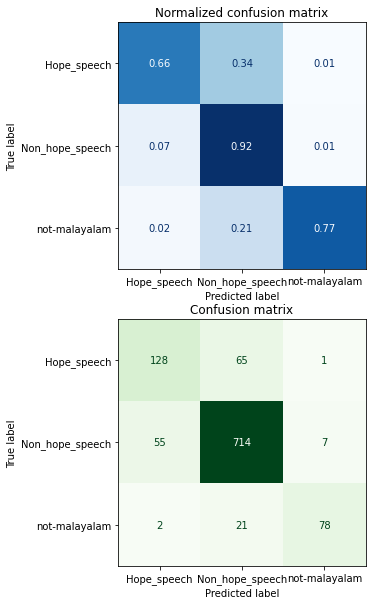

In [46]:
plot_confusion_matrix(y_pred_test, y_test, labels)

In [72]:
#!zip -r /content/distilm.zip /content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670

  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/ (stored 0%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/optimizer.pt (deflated 67%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/training_args.bin (deflated 48%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/config.json (deflated 49%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/tokenizer.json (deflated 67%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/scheduler.pt (deflated 49%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/vocab.txt (deflated 45%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/trainer_state.json (deflated 77%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-2670/pytorch_model.bin (deflate

In [47]:
from transformers import AutoTokenizer

indicbert_model_ckpt = "ai4bharat/indic-bert"
indic_tokenizer = AutoTokenizer.from_pretrained(indicbert_model_ckpt)

In [46]:
indic_tokenizer.model_max_length=max_len

In [47]:
indic_tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [48]:
indic_tokenizer.vocab_size

200000

In [49]:
def indic_tokenize(batch):
    return indic_tokenizer(batch["text"], padding=True, truncation=True)

In [50]:
hope_edi_indic_encoded = hope_edi.map(indic_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
print(hope_edi_indic_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [48]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
indic_model = (AutoModelForSequenceClassification
         .from_pretrained(indicbert_model_ckpt, num_labels=num_labels)
         .to(device))

In [53]:
from transformers import Trainer, TrainingArguments

logging_steps = len(hope_edi_indic_encoded["train"]) // batch_size
indic_model_name = f"{indicbert_model_ckpt}-finetuned-hope"
indic_training_args = TrainingArguments(output_dir=indic_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [54]:
indic_trainer = CustomTrainer(model=indic_model, args=indic_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_indic_encoded["train"],
                  eval_dataset=hope_edi_indic_encoded["validation"],
                  tokenizer=indic_tokenizer)
indic_trainer.train();

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.584300,0.567434,0.741121,0.757649,0.799511,0.741121
2,0.423100,0.473366,0.828037,0.802173,0.824450,0.828037
3,0.329000,0.450717,0.829907,0.815079,0.818903,0.829907
4,0.236800,0.531382,0.834579,0.829705,0.827232,0.834579
5,0.163000,0.739375,0.819626,0.819951,0.820291,0.819626
6,0.085400,0.864953,0.823364,0.820618,0.818600,0.823364


In [55]:
preds_indic_output = indic_trainer.predict(hope_edi_indic_encoded["validation"])
preds_indic_output.metrics

{'test_loss': 0.864952564239502,
 'test_accuracy': 0.8233644859813084,
 'test_f1': 0.8206178444237385,
 'test_precision': 0.8186000205344948,
 'test_recall': 0.8233644859813084,
 'test_runtime': 8.947,
 'test_samples_per_second': 119.593,
 'test_steps_per_second': 7.489}

In [56]:
import numpy as np
indic_y_preds = np.argmax(preds_indic_output.predictions, axis=1)
indic_y_valid = np.array(hope_edi_indic_encoded["validation"]["label"])
indic_labels = hope_edi_indic_encoded["validation"].features["label"].names

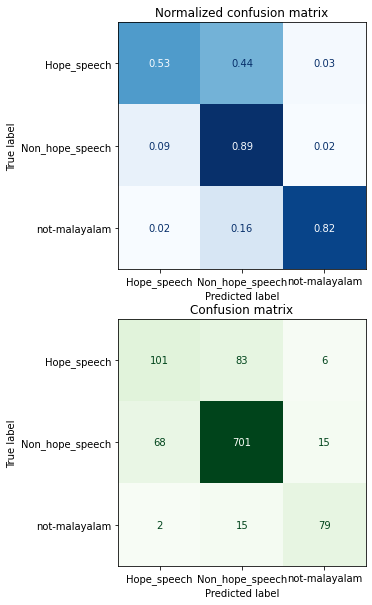

In [57]:
plot_confusion_matrix(indic_y_preds, indic_y_valid, indic_labels)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(indic_y_valid, indic_y_preds))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       190
           1       0.88      0.89      0.89       784
           2       0.79      0.82      0.81        96

    accuracy                           0.82      1070
   macro avg       0.75      0.75      0.75      1070
weighted avg       0.82      0.82      0.82      1070



In [59]:
preds_indic_train = indic_trainer.predict(hope_edi_indic_encoded["train"])
indic_y_pred_train = np.argmax(preds_indic_train.predictions, axis=1)
indic_y_train = np.array(hope_edi_indic_encoded["train"]["label"])
print(classification_report(indic_y_train, indic_y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1668
           1       0.99      0.99      0.99      6205
           2       0.97      0.98      0.98       691

    accuracy                           0.99      8564
   macro avg       0.98      0.98      0.98      8564
weighted avg       0.99      0.99      0.99      8564



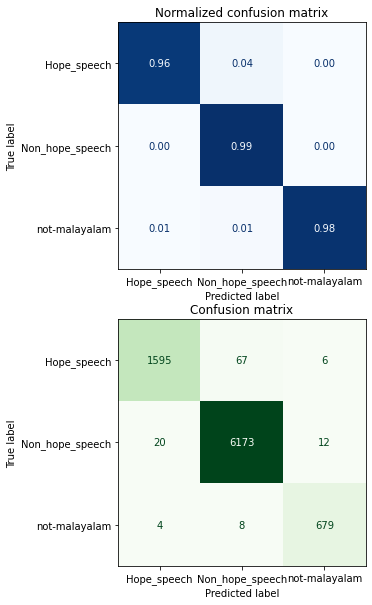

In [64]:
plot_confusion_matrix(indic_y_pred_train, indic_y_train, labels)

In [60]:
hope_edi_test_indic_encoded = hope_edi_test.map(indic_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
preds_indic_test = indic_trainer.predict(hope_edi_test_indic_encoded["test"])
indic_y_pred_test = np.argmax(preds_indic_test.predictions, axis=1)
indic_y_test = np.array(hope_edi_test_indic_encoded["test"]["label"])
print(classification_report(indic_y_test, indic_y_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       194
           1       0.88      0.91      0.89       776
           2       0.86      0.76      0.81       101

    accuracy                           0.84      1071
   macro avg       0.79      0.75      0.77      1071
weighted avg       0.83      0.84      0.83      1071



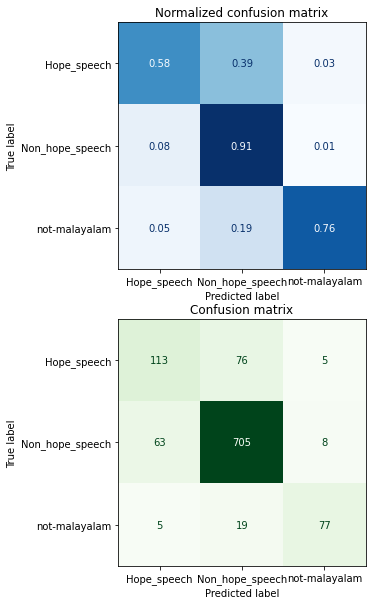

In [65]:
plot_confusion_matrix(indic_y_pred_test, indic_y_test, labels)

In [71]:
#!zip -r /content/indic.zip /content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670 

  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/ (stored 0%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/optimizer.pt (deflated 76%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/training_args.bin (deflated 48%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/config.json (deflated 54%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/tokenizer.json (deflated 77%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/scheduler.pt (deflated 49%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/trainer_state.json (deflated 77%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/pytorch_model.bin (deflated 7%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/special_tokens_map.json (deflated 49%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-2670/spiece.model (deflated 60%)
  adding

In [45]:
from transformers import AutoTokenizer

muril_model_ckpt = "google/muril-base-cased"
muril_tokenizer = AutoTokenizer.from_pretrained(muril_model_ckpt)

In [66]:
muril_tokenizer.model_max_length=max_len

In [67]:
muril_tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [68]:
muril_tokenizer.vocab_size

197285

In [69]:
def muril_tokenize(batch):
    return muril_tokenizer(batch["text"], padding=True, truncation=True)

In [70]:
hope_edi_muril_encoded = hope_edi.map(muril_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [71]:
print(hope_edi_muril_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [72]:
hope_edi_test_muril_encoded = hope_edi_test.map(muril_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
muril_model = (AutoModelForSequenceClassification
         .from_pretrained(muril_model_ckpt, num_labels=num_labels)
         .to(device))

In [74]:
from transformers import Trainer, TrainingArguments
epochs = 4
batch_size = 32
logging_steps = len(hope_edi_muril_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
muril_model_name = f"{muril_model_ckpt}-finetuned-hope"
muril_training_args = TrainingArguments(output_dir=muril_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [75]:
muril_trainer = CustomTrainer(model=muril_model, args=muril_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_muril_encoded["train"],
                  eval_dataset=hope_edi_muril_encoded["validation"],
                  tokenizer=muril_tokenizer)
muril_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.728200,0.578867,0.784112,0.708259,0.645799,0.784112
2,0.503300,0.444139,0.849533,0.845098,0.844650,0.849533
3,0.352600,0.401445,0.862617,0.863198,0.863947,0.862617
4,0.257600,0.404687,0.861682,0.860744,0.860168,0.861682


TrainOutput(global_step=1072, training_loss=0.45947108684635873, metrics={'train_runtime': 876.3399, 'train_samples_per_second': 39.09, 'train_steps_per_second': 1.223, 'total_flos': 4506606618845184.0, 'train_loss': 0.45947108684635873, 'epoch': 4.0})

In [76]:
preds_muril_output = muril_trainer.predict(hope_edi_muril_encoded["validation"])
preds_muril_output.metrics

{'test_loss': 0.4046873152256012,
 'test_accuracy': 0.8616822429906542,
 'test_f1': 0.8607437718654743,
 'test_precision': 0.8601677282834863,
 'test_recall': 0.8616822429906542,
 'test_runtime': 8.0047,
 'test_samples_per_second': 133.672,
 'test_steps_per_second': 4.248}

In [77]:
import numpy as np
muril_y_preds = np.argmax(preds_muril_output.predictions, axis=1)
muril_y_valid = np.array(hope_edi_muril_encoded["validation"]["label"])
muril_labels = hope_edi_muril_encoded["validation"].features["label"].names

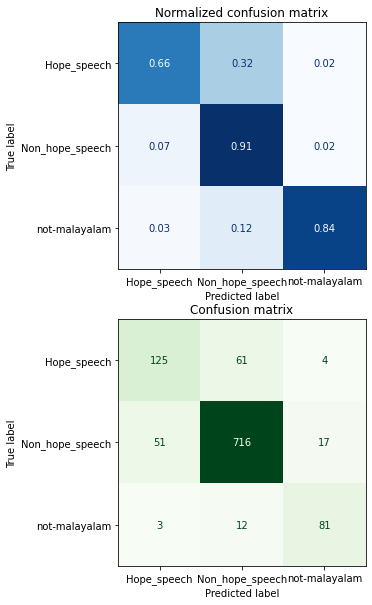

In [78]:
plot_confusion_matrix(muril_y_preds, muril_y_valid, muril_labels)

In [79]:
from sklearn.metrics import classification_report
print(classification_report(muril_y_valid, muril_y_preds))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       190
           1       0.91      0.91      0.91       784
           2       0.79      0.84      0.82        96

    accuracy                           0.86      1070
   macro avg       0.80      0.80      0.80      1070
weighted avg       0.86      0.86      0.86      1070



In [80]:
preds_muril_train = muril_trainer.predict(hope_edi_muril_encoded["train"])
muril_y_pred_train = np.argmax(preds_muril_train.predictions, axis=1)
muril_y_train = np.array(hope_edi_muril_encoded["train"]["label"])
print(classification_report(muril_y_train, muril_y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1668
           1       0.97      0.97      0.97      6205
           2       0.92      0.96      0.94       691

    accuracy                           0.95      8564
   macro avg       0.93      0.93      0.93      8564
weighted avg       0.95      0.95      0.95      8564



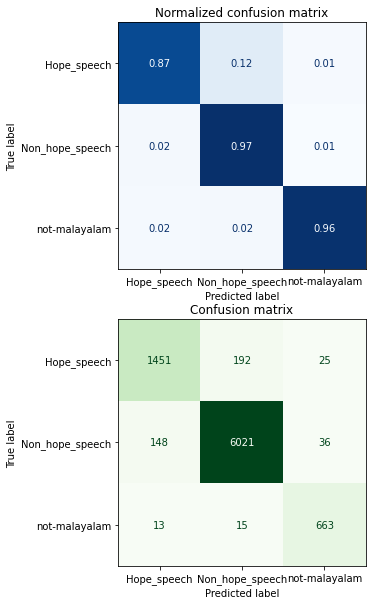

In [81]:
plot_confusion_matrix(muril_y_pred_train, muril_y_train, muril_labels)

In [82]:
preds_muril_test = muril_trainer.predict(hope_edi_test_muril_encoded["test"])
muril_y_pred_test = np.argmax(preds_muril_test.predictions, axis=1)
muril_y_test = np.array(hope_edi_test_muril_encoded["test"]["label"])
print(classification_report(muril_y_test, muril_y_pred_test))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       194
           1       0.90      0.89      0.90       776
           2       0.83      0.81      0.82       101

    accuracy                           0.85      1071
   macro avg       0.79      0.79      0.79      1071
weighted avg       0.85      0.85      0.85      1071



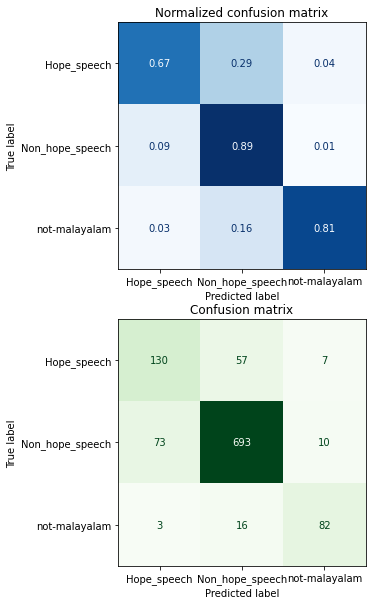

In [83]:
plot_confusion_matrix(muril_y_pred_test, muril_y_test, muril_labels)

In [73]:
#!zip -r /content/muril.zip /content/google/muril-base-cased-finetuned-hope/checkpoint-2670

  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/ (stored 0%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/optimizer.pt (deflated 62%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/training_args.bin (deflated 48%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/config.json (deflated 52%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/tokenizer.json (deflated 70%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/scheduler.pt (deflated 49%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/vocab.txt (deflated 61%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/trainer_state.json (deflated 79%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/pytorch_model.bin (deflated 7%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-2670/special_tokens_map.j

In [24]:
from transformers import AutoTokenizer

xlmr_model_ckpt = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_ckpt)

In [25]:
xlmr_tokenizer.model_max_length=max_len

In [26]:
def xlmr_tokenize(batch):
    return xlmr_tokenizer(batch["text"], padding=True, truncation=True)

In [27]:
hope_edi_xlmr_encoded = hope_edi.map(xlmr_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
hope_edi_test_xlmr_encoded = hope_edi_test.map(xlmr_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [29]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
xlmr_model = (AutoModelForSequenceClassification
         .from_pretrained(xlmr_model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [30]:
from transformers import Trainer, TrainingArguments
batch_size = 32
epochs = 4
logging_steps = len(hope_edi_xlmr_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
xlmr_model_name = f"{xlmr_model_ckpt}-finetuned-hope"
xlmr_training_args = TrainingArguments(output_dir=xlmr_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [31]:
xlmr_trainer = CustomTrainer(model=xlmr_model, args=xlmr_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_xlmr_encoded["train"],
                  eval_dataset=hope_edi_xlmr_encoded["validation"],
                  tokenizer=xlmr_tokenizer)
xlmr_trainer.train();

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.635400,0.632448,0.772897,0.697607,0.635683,0.772897
2,0.474600,0.487693,0.787850,0.795683,0.813914,0.787850
3,0.353200,0.423162,0.842056,0.832638,0.834201,0.842056
4,0.298900,0.441634,0.825234,0.826806,0.829131,0.825234


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
preds_xlmr_output = xlmr_trainer.predict(hope_edi_xlmr_encoded["validation"])
preds_xlmr_output.metrics

{'test_loss': 0.4416339695453644,
 'test_accuracy': 0.8252336448598131,
 'test_f1': 0.8268055266135504,
 'test_precision': 0.8291313727106125,
 'test_recall': 0.8252336448598131,
 'test_runtime': 7.9559,
 'test_samples_per_second': 134.491,
 'test_steps_per_second': 4.274}

In [33]:
import numpy as np
xlmr_y_preds = np.argmax(preds_xlmr_output.predictions, axis=1)
xlmr_y_valid = np.array(hope_edi_xlmr_encoded["validation"]["label"])
xlmr_labels = hope_edi_xlmr_encoded["validation"].features["label"].names

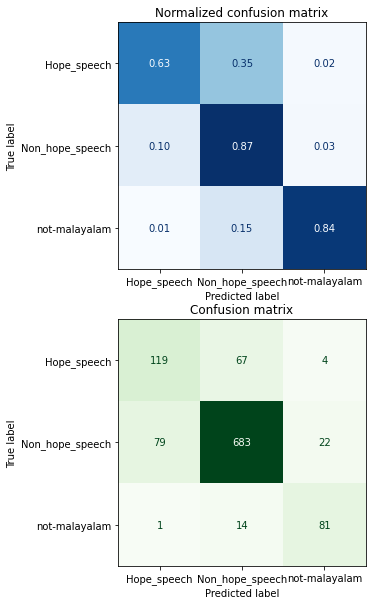

In [34]:
plot_confusion_matrix(xlmr_y_preds, xlmr_y_valid, xlmr_labels)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(xlmr_y_valid, xlmr_y_preds))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61       190
           1       0.89      0.87      0.88       784
           2       0.76      0.84      0.80        96

    accuracy                           0.83      1070
   macro avg       0.75      0.78      0.76      1070
weighted avg       0.83      0.83      0.83      1070



In [36]:
preds_xlmr_train = xlmr_trainer.predict(hope_edi_xlmr_encoded["train"])
xlmr_y_pred_train = np.argmax(preds_xlmr_train.predictions, axis=1)
xlmr_y_train = np.array(hope_edi_xlmr_encoded["train"]["label"])
print(classification_report(xlmr_y_train, xlmr_y_pred_train))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1668
           1       0.94      0.93      0.94      6205
           2       0.92      0.94      0.93       691

    accuracy                           0.91      8564
   macro avg       0.88      0.89      0.88      8564
weighted avg       0.91      0.91      0.91      8564



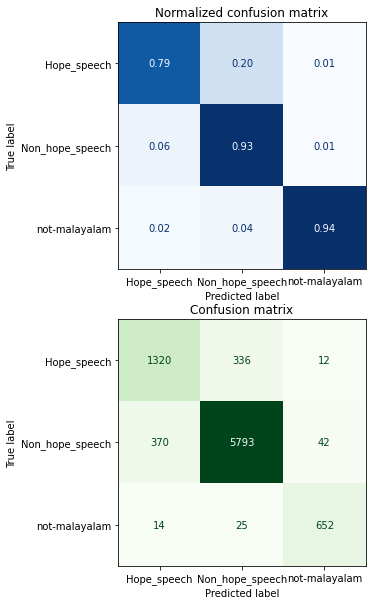

In [37]:
plot_confusion_matrix(xlmr_y_pred_train, xlmr_y_train, xlmr_labels)

In [38]:
preds_xlmr_test = xlmr_trainer.predict(hope_edi_test_xlmr_encoded["test"])
xlmr_y_pred_test = np.argmax(preds_xlmr_test.predictions, axis=1)
xlmr_y_test = np.array(hope_edi_test_xlmr_encoded["test"]["label"])
print(classification_report(xlmr_y_test, xlmr_y_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       194
           1       0.91      0.88      0.90       776
           2       0.81      0.82      0.82       101

    accuracy                           0.84      1071
   macro avg       0.78      0.80      0.79      1071
weighted avg       0.85      0.84      0.84      1071



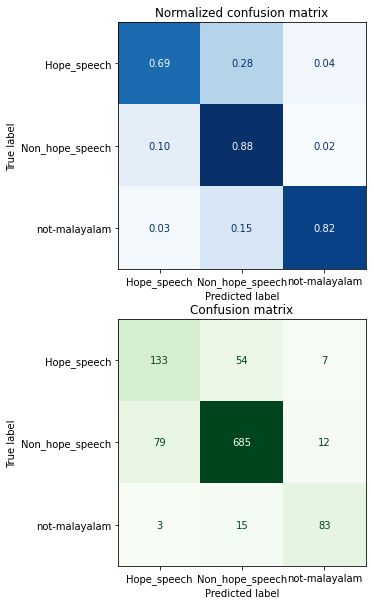

In [39]:
plot_confusion_matrix(xlmr_y_pred_test, xlmr_y_test, xlmr_labels)

In [35]:
#!zip -r /content/xlmr.zip /content/xlm-roberta-base-finetuned-hope/checkpoint-2670

  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/ (stored 0%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/optimizer.pt (deflated 68%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/training_args.bin (deflated 48%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/config.json (deflated 52%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/sentencepiece.bpe.model (deflated 49%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/tokenizer.json (deflated 76%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/scheduler.pt (deflated 49%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/trainer_state.json (deflated 77%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/pytorch_model.bin (deflated 25%)
  adding: content/xlm-roberta-base-finetuned-hope/checkpoint-2670/special_tokens_map.json (deflated 52%)
  adding: content/xlm-roberta-base-f

In [95]:
print(xlmr_model)

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [96]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
from torchinfo import summary

In [98]:
summary(xlmr_model)

Layer (type:depth-idx)                                       Param #
XLMRobertaForSequenceClassification                          --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   192,001,536
│    │    └─Embedding: 3-2                                   394,752
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           2,307
T

In [99]:
summary(muril_model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              151,514,880
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 2

In [100]:
summary(indic_model)

Layer (type:depth-idx)                                       Param #
AlbertForSequenceClassification                              --
├─AlbertModel: 1-1                                           --
│    └─AlbertEmbeddings: 2-1                                 --
│    │    └─Embedding: 3-1                                   25,600,000
│    │    └─Embedding: 3-2                                   65,536
│    │    └─Embedding: 3-3                                   256
│    │    └─LayerNorm: 3-4                                   256
│    │    └─Dropout: 3-5                                     --
│    └─AlbertTransformer: 2-2                                --
│    │    └─Linear: 3-6                                      99,072
│    │    └─ModuleList: 3-7                                  7,087,872
│    └─Linear: 2-3                                           590,592
│    └─Tanh: 2-4                                             --
├─Dropout: 1-2                                               --
├─Lin

In [101]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              91,812,096
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 135,326,979
Trainable params: 135,326,979
Non-trainable params: 0

In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
print(indic_model)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768

In [ ]:
print(muril_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [41]:
xlmr_model.config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [44]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.2",
  "vocab_size": 119547
}

In [49]:
muril_model.config

BertConfig {
  "_name_or_path": "google/muril-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 197285
}

In [50]:
indic_model.config

AlbertConfig {
  "_name_or_path": "ai4bharat/indic-bert",
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "vocab_size": 200000
}